# Laboratorio 4: Clasificación de Imágenes con CNN (CIFAR-10)

**Integrantes**
- José Rodrigo Marchena, 22398  
- Sofía Velasquez, 22049  

**Objetivo general**  
Implementar y comparar un modelo base ANN y una CNN para clasificar el dataset CIFAR-10,evaluando desempeño, curvas de aprendizaje y errores comunes. También se incluye un ejercicio opcional de Data Augmentation.

---

## Parte 1: Preparación del Conjunto de Datos

1. Cargamos el dataset CIFAR-10 directamente desde `keras.datasets`.  
   - Son 60,000 imágenes de tamaño 32x32x3 (RGB).  
   - Se dividen en 50,000 de entrenamiento y 10,000 de prueba.  
2. Normalizamos los valores de píxeles, dividiéndolos entre 255, de modo que los valores queden en el rango [0,1]. Cómo las imagenes son arrays entre 0 y 255 de la intensidad de cada pixel.
3. Definimos los nombres de las clases (avión, coche, perro, etc.).  
4. Mostramos 10 imágenes de entrenamiento con sus etiquetas para confirmar que los datos están bien cargados.

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 44s 0us/step
Shapes -> x_train: (50000, 32, 32, 3) y_train: (50000, 1)
Shapes -> x_test: (10000, 32, 32, 3) y_test: (10000, 1)


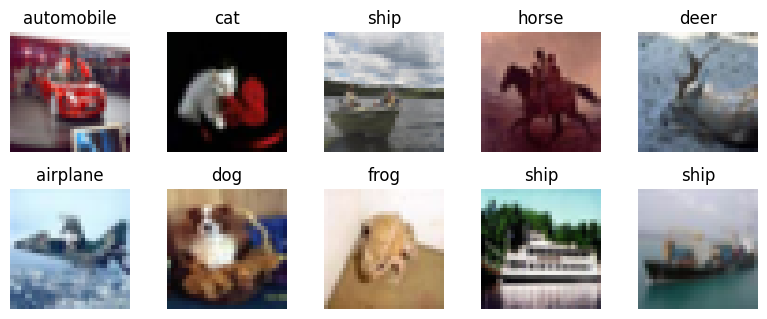

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data() # Carga de CIFAR-10 dataset y de una vez sacar los x,y train y test

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck'] # Definir los nombres de las clases

# Mostrar las formas de los conjuntos de datos
print("Shapes -> x_train:", x_train.shape, "y_train:", y_train.shape) 
print("Shapes -> x_test:", x_test.shape, "y_test:", y_test.shape)

# Normalización [0,1]
x_train = x_train.astype("float32") / 255.0 
x_test  = x_test.astype("float32") / 255.0

# Visualización de 10 ejemplos
def show_grid(images, labels, n=10):
    plt.figure(figsize=(8,8))
    idx = np.random.choice(len(images), n, replace=False)
    for i, j in enumerate(idx):
        plt.subplot(5,5,i+1)
        plt.imshow(images[j])
        plt.title(class_names[labels[j][0]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_grid(x_train, y_train)

## Parte 2: Modelo Base ANN

Se define una función `build_ann` qué implementa una red neuronal artificial densa (ANN):

- Se aplana la imagen (32×32×3 → 3072 neuronas).  
- Dos capas densas ocultas con activación ReLU.  
- Capa final Dense(10) con activación Softmax para clasificar las 10 clases.  

Se compila el modelo con:
- **Optimizer:** Adam.  
- **Loss:** categorical_crossentropy.  
- **Métrica:** Accuracy.  

Luego lo entrenamos, medimos tiempo de entrenamiento y evaluamos el rendimiento en el set de prueba.

In [2]:
import time
from tensorflow.keras.utils import to_categorical

# One-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Función para construir el modelo ANN
def build_ann(input_shape=(32,32,3), num_classes=10):
    model = keras.Sequential([ 
        layers.Flatten(input_shape=input_shape), # Aplanar la imagen 32x32x3 a un vector de 3072
        layers.Dense(512, activation="relu"), # Capa oculta con 512 neuronas y activación ReLU
        layers.Dense(256, activation="relu"), # Capa oculta con 256 neuronas y activación ReLU
        layers.Dense(num_classes, activation="softmax") # Capa de salida con activación softmax
    ])
    model.compile(optimizer='adam', 
              loss='categorical_crossentropy', # Función de pérdida para clasificación multiclase
              metrics=['accuracy']) # Métrica de precisión
    return model

# Construcción del modelo ANN
ann = build_ann()
# Mostrar resumen del modelo
ann.summary()

C:\Users\JM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,707,274 (6.51 MB)

 Trainable params: 1,707,274 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento del modelo ANN
En este bloque de código se entrena el modelo(ANN):
Se define: 
- `batch_size = 64` que va a ser el tamaño del lote
- `epochs = 10` que van a ser las epocas que va a recorrer el modelo

Para el entrenamiento se le pasan los parametros a la función para entrenar el modelo: 
- Se le mandan los conjuntos de entrenamiento
- El `validation_split=0.2` para usar 20% de los datos de entrenamiento para validación
- El `batch_size`y `epochs`
- El `verbose=2` para mostrar información detallada durante el entrenamiento

In [ ]:
# Entrenamiento ANN
ann = build_ann()
batch_size = 64 
epochs = 10 

start = time.time() # Inicio del temporizador
hist_ann = ann.fit(
    x_train, y_train,
    validation_split=0.2, # Usar 20% de los datos de entrenamiento para validación
    batch_size=batch_size,
    epochs=epochs,
    verbose=2 # Mostrar información detallada durante el entrenamiento
)
t_train_ann = time.time() - start # fin del temporizador
# Mostrar tiempo de entrenamiento
print(f"Tiempo de entrenamiento ANN: {t_train_ann:.2f} s")

# Evaluación del modelo en test
test_loss_ann, test_acc_ann = ann.evaluate(x_test, y_test, verbose=0)
print(f"[ANN] Test Acc: {test_acc_ann:.4f} | Test Loss: {test_loss_ann:.4f}")


Epoch 1/10
625/625 - 18s - 28ms/step - accuracy: 0.3171 - loss: 1.9101 - val_accuracy: 0.3634 - val_loss: 1.7818
Epoch 2/10
625/625 - 16s - 26ms/step - accuracy: 0.3871 - loss: 1.7027 - val_accuracy: 0.4085 - val_loss: 1.6564
Epoch 3/10
625/625 - 16s - 26ms/step - accuracy: 0.4251 - loss: 1.6105 - val_accuracy: 0.4203 - val_loss: 1.6307
Epoch 4/10
625/625 - 16s - 26ms/step - accuracy: 0.4449 - loss: 1.5484 - val_accuracy: 0.4392 - val_loss: 1.5872
Epoch 5/10
625/625 - 16s - 25ms/step - accuracy: 0.4602 - loss: 1.5079 - val_accuracy: 0.4412 - val_loss: 1.5749
Epoch 6/10
625/625 - 16s - 25ms/step - accuracy: 0.4768 - loss: 1.4652 - val_accuracy: 0.4671 - val_loss: 1.5175
Epoch 7/10
625/625 - 16s - 25ms/step - accuracy: 0.4835 - loss: 1.4448 - val_accuracy: 0.4629 - val_loss: 1.5391
Epoch 8/10
625/625 - 16s - 25ms/step - accuracy: 0.4943 - loss: 1.4155 - val_accuracy: 0.4673 - val_loss: 1.5122
Epoch 9/10
625/625 - 16s - 25ms/step - accuracy: 0.5017 - loss: 1.3949 - val_accuracy: 0.4751 - 

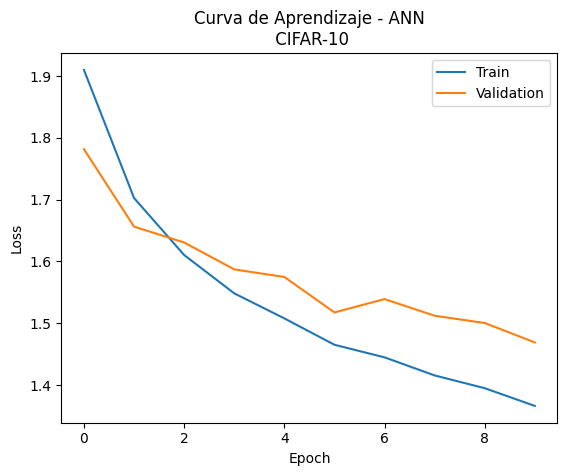

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.50      0.60      0.55      1000
           1       0.70      0.45      0.55      1000
           2       0.39      0.33      0.36      1000
           3       0.33      0.27      0.30      1000
           4       0.45      0.38      0.41      1000
           5       0.39      0.42      0.40      1000
           6       0.46      0.63      0.53      1000
           7       0.62      0.46      0.53      1000
           8       0.50      0.70      0.59      1000
           9       0.53      0.57      0.55      1000

    accuracy                           0.48     10000
   macro avg       0.49      0.48      0.48     10000
weighted avg       0.49      0.48      0.48     10000



Text(0.5, 1.0, 'ANN - Matriz de Confusion\n CIFAR-10')

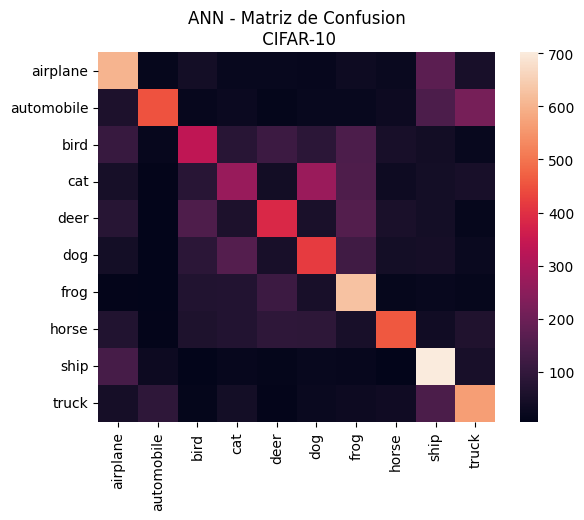

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Learning Curve
plt.title("Curva de Aprendizaje - ANN\n CIFAR-10")
plt.plot(np.arange(0,epochs), hist_ann.history["loss"], label="Train")
plt.plot(np.arange(0,epochs), hist_ann.history["val_loss"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Confusion Matrix
y_pred_prob = ann.predict(x_test)
y_pred_class = np.argmax(y_pred_prob,axis=1)
y_test_class = np.argmax(y_test, axis=1)
print(classification_report(y_test_class, y_pred_class))
cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names)
plt.title("ANN - Matriz de Confusion\n CIFAR-10")

## Parte 3: Implementación de CNN

Se define una función `build_cnn` para diseñar una red neuronal convolucional (CNN):

- Varias capas Conv2D con filtros (32, 64, 128).  
- Capas de MaxPooling2D para reducir la dimensión espacial.  
- Dropout en puntos estratégicos para reducir sobreajuste.  
- Al final, una capa densa y salida Softmax de 10 clases.  

Luego se registra el tiempo de entrenamiento y se evalúa con los datos de prueba.

In [43]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Función para construir el modelo CNN
def build_cnn(input_shape=(32,32,3), num_classes=10, dropout_rate=0.3):
    model = keras.Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape), # Capa convolucional 1 con filtro 32 y activación ReLU
        MaxPooling2D((2,2)), # Capa de max pooling 1
        Dropout(dropout_rate),
        Conv2D(64, (3,3), activation='relu', padding='same'), # Capa convolucional 2 con filtro 64 y activación ReLU
        MaxPooling2D((2,2)), # Capa de max pooling 2   
        Dropout(dropout_rate),
        Conv2D(128, (3,3), activation='relu', padding='same'), # Capa convolucional 3 con filtro 128 y activación ReLU
        MaxPooling2D((2,2)), # Capa de max pooling 3    
        Dropout(dropout_rate),
        Flatten(), # Aplanar las características extraídas
        Dense(256, activation='relu'), # Capa densa oculta con 256 neuronas y activación ReLU
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')  # Capa de salida con activación softmax
    ])
    model.compile( # Compilación del modelo
        optimizer='adam',
        loss="categorical_crossentropy", # Función de pérdida para clasificación multiclase
        metrics=["accuracy"] # Métrica de precisión
    )
    return model

# Construcción del modelo CNN
cnn = build_cnn()
# Mostrar resumen del modelo
cnn.summary()


C:\Users\JM\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 620,362 (2.37 MB)

 Trainable params: 620,362 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento del modelo CNN
En este bloque de código se entrena el modelo(ANN):

Se llama a la función para entrenar el modelo: 
  - Se mandan los conjuntos de entrenamiento, `epochs = 10` , `validation_split=0.2`, `batch_size = 64`, `verbose=2` que es exactamente lo mismo que se le mandó al modelo ann
  - Solo se le agrega `callbacks=[early]`
    -  Entrenamos el modelo usando validación y `EarlyStopping` para detener si no mejora la accuracy en validación.  


In [44]:
early = keras.callbacks.EarlyStopping( # Callback para detener el entrenamiento temprano
    monitor="val_accuracy", # Monitorear la precisión en el conjunto de validación
    patience=5, # Paciencia para detener el entrenamiento
    restore_best_weights=True # Restaurar los mejores pesos al detener el entrenamiento
)

start = time.time() # Inicio del temporizador
# Entrenamiento del modelo CNN
hist_cnn = cnn.fit(
    x_train, y_train, # Datos de entrenamiento
    validation_split=0.2, # Usar 20% de los datos de entrenamiento para validación
    batch_size=64, # Tamaño del lote
    epochs=10, #
    callbacks=[early],
    verbose=2
)
t_train_cnn = time.time() - start # Tiempo de entrenamiento
print(f"Tiempo de entrenamiento CNN: {t_train_cnn:.2f} s")

test_loss_cnn, test_acc_cnn = cnn.evaluate(x_test, y_test, verbose=0)
print(f"[CNN] Test Acc: {test_acc_cnn:.4f} | Test Loss: {test_loss_cnn:.4f}")

Epoch 1/10
625/625 - 28s - 45ms/step - accuracy: 0.3816 - loss: 1.6806 - val_accuracy: 0.5168 - val_loss: 1.3471
Epoch 2/10
625/625 - 26s - 41ms/step - accuracy: 0.5312 - loss: 1.3001 - val_accuracy: 0.6029 - val_loss: 1.1240
Epoch 3/10
625/625 - 29s - 47ms/step - accuracy: 0.5871 - loss: 1.1570 - val_accuracy: 0.6512 - val_loss: 0.9917
Epoch 4/10
625/625 - 29s - 47ms/step - accuracy: 0.6246 - loss: 1.0568 - val_accuracy: 0.6769 - val_loss: 0.9250
Epoch 5/10
625/625 - 28s - 45ms/step - accuracy: 0.6486 - loss: 0.9901 - val_accuracy: 0.6976 - val_loss: 0.8747
Epoch 6/10
625/625 - 29s - 47ms/step - accuracy: 0.6687 - loss: 0.9328 - val_accuracy: 0.7092 - val_loss: 0.8355
Epoch 7/10
625/625 - 28s - 45ms/step - accuracy: 0.6877 - loss: 0.8935 - val_accuracy: 0.7095 - val_loss: 0.8203
Epoch 8/10
625/625 - 29s - 46ms/step - accuracy: 0.6971 - loss: 0.8539 - val_accuracy: 0.7348 - val_loss: 0.7713
Epoch 9/10
625/625 - 29s - 47ms/step - accuracy: 0.7085 - loss: 0.8241 - val_accuracy: 0.7346 - 